# Using neural networks to parameterize advection in L96

In [1]:
%matplotlib inline
import math

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from L96_model_XYtend import (  # L96_model_XYtend Adds the option to ouptput the subgrid tendencies (effect of Y on X)
    L96,
    RK2,
    RK4,
    EulerFwd,
    L96_eq1_xdot,
    integrate_L96_2t,
)
from matplotlib.animation import FuncAnimation

time_method = EulerFwd

# Introduction

We are only going to use the single equation model from [Lorenz (1996)](https://www.ecmwf.int/en/elibrary/10829-predictability-problem-partly-solved), or equation 3.1:
\begin{align}
\frac{d}{dt} X_k
= - X_{k-1} \left( X_{k-2} - X_{k+1} \right) - X_k + F
\end{align}

The reason we do this is because the advection term has a much larger control on the stability of the system than the scale-interaction term.  It is fairly difficult to learn a model for the sub-grid scale term that causes L96 to go unstable so long as the timestep is sufficient to keep the advection term stable.

We want to to look into the stability of a learned parameterization, but to explore the stability in more detail we are going to focus on learning a neural-network for the advection.

It turns out this is rather challening, despite some early indications that it would be easy while I was still learning how to do everything!

## Building a 1d and 2d version of the single-equation L96 model:

The '1d' in time, or advectionless version of L96 reduces to:
\begin{align}
\frac{d}{dt} X_k
= - X_k + F,
\end{align}
the steady state solution is simply:

\begin{align}
X_k=F,
\end{align}

and the time-dependent solution is an exponential:

\begin{align}
X_k
= \left(F- (F-X_k^0)\exp(-t) \right).
\end{align}


We are going to generate both 2d (w/ advection) and 1d (w/o advection) versions of the L96 model.  The 2d model will then be used as training data to build a non-local neural network that can reproduce the effect of including the advection term.



In [2]:
# - This is a standard GCM class including a polynomial parameterization in rhs of equation for tendency.
#  In this experiment we will not be using the parameterization in this class but have left it for generality.
class GCM:
    def __init__(self, F, parameterization, time_stepping=time_method):
        self.F = F
        self.parameterization = parameterization
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        return L96_eq1_xdot(X, self.F) + self.parameterization(param, X, self.F)

    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

In [3]:
# - This is the same as the GCM with one notable exception.
#  We have set the advection flag to False in the RHS of the L96 equation.
class GCM_1d:
    def __init__(self, F, parameterization, time_stepping=time_method):
        self.F = F
        self.parameterization = parameterization
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        return L96_eq1_xdot(X, self.F, advect=False) + self.parameterization(
            param, X, self.F
        )

    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

## Sample configuration

First we will run the 2d and 1d version of the model with a modest forcing of $F=10$.

We are going to try to simulate the effect of climate model drift on parameter space by running the same model but with $F=100$.

In [4]:
# Chose a modest forcing and simulate for 100 cycles
Forcing, dt, T = 10, 0.001, 10
Forcing_x10 = Forcing * 10

# Choose an random set of initial conditions
b = 5
init_cond = b * np.random.randn(8)

# ----------------------------------------------------------------
# We create the template 2d GCM here with the polynomial parameterization
# this model will be used to generate training data to learn the advection term.
naive_parameterization = lambda param, X, F: np.polyval(param, X)
gcm_2d = GCM(Forcing, naive_parameterization)

# ----------------------------------------------------------------
# We also create a super GCM for simulation with the forcing of 100.
# This will be used as the truth when we test the ability of the 1d model with the neural network to
# work outside of the parmameter space it was trained.
gcm_2d_x10 = GCM(Forcing_x10, naive_parameterization)

# ----------------------------------------------------------------
# Finally,we build the 1d GCM including the polynomial parameterization,
# and we create the corresponding super GCM with forcing squared.
gcm_1d = GCM_1d(Forcing, naive_parameterization)
gcm_1d_x10 = GCM_1d(Forcing_x10, naive_parameterization)

In [5]:
# Running the 2d and 1d versions of the GCM and GCM with F=100 ("_x10")

x2d, t2d = gcm_2d(
    init_cond,
    dt,
    int(T / dt),
    [
        0.0,
    ],
)
x2d_x10, t2d_x10 = gcm_2d_x10(
    init_cond,
    dt,
    int(T / dt),
    [
        0.0,
    ],
)

x1d, t1d = gcm_1d(
    init_cond,
    dt,
    int(T / dt),
    [
        0.0,
    ],
)
x1d_x10, t1d_x10 = gcm_1d_x10(
    init_cond,
    dt,
    int(T / dt),
    [
        0.0,
    ],
)

/net2/bgr/anaconda3/envs/ML/lib/python3.7/site-packages/numpy/lib/polynomial.py:734: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


## Metrics:

We are going to track the momentum and energy of L96 via the following metrics:

#### Momentum:
\begin{align}
p = \sum_k X_k
\end{align}


#### Energy:
\begin{align}
e = \sum_k X_k^2
\end{align}


These metrics are chosen to track the system.  We are looking for a conservative property of the L96 system.  It turns out in the single equation form of the L96 problem one of these two metrics is conserved by the advection process, which is the energy like term.


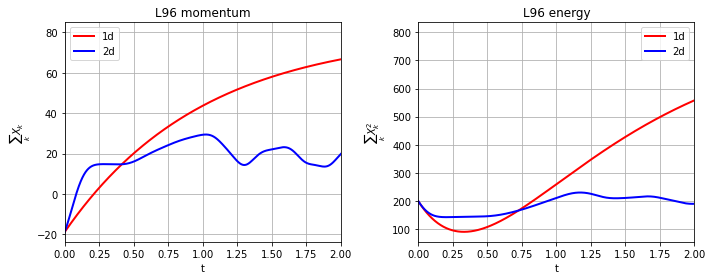

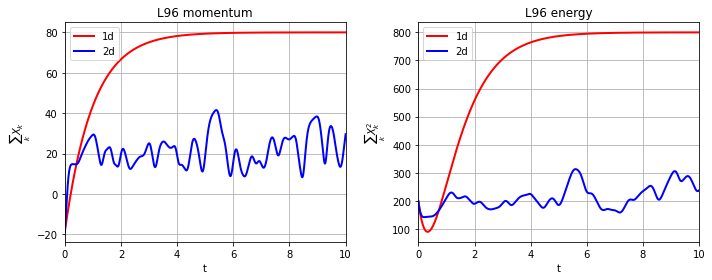

In [6]:
for tup in [2, T]:
    F, ax = plt.subplots(1, 2, figsize=(10, 4))

    a = ax.ravel()[0]
    a.plot(t1d, np.sum(x1d, axis=1), label="1d", color="r", linewidth=2)
    a.plot(t2d, np.sum(x2d, axis=1), label="2d", color="b", linewidth=2)
    a.legend()
    a.grid(True)
    a.set_title("L96 momentum")
    a.set_xlabel("t")
    a.set_ylabel(r"$\sum_k X_k$")
    a.set_xlim(0, tup)

    a = ax.ravel()[1]
    a.plot(t1d, np.sum(x1d**2, axis=1), label="1d", color="r", linewidth=2)
    a.plot(t2d, np.sum(x2d**2, axis=1), label="2d", color="b", linewidth=2)
    a.legend()
    a.grid(True)
    a.set_title("L96 energy")
    a.set_xlabel("t")
    a.set_ylabel(r"$\sum_k X_k^2$")
    a.set_xlim(0, tup)

    F.tight_layout();

# Demo: Conservation of energy in L96

To demonstrate the conservation of energy in L96 advection we build a model with 0 forcing and 0 damping.

Note that the cyan line is an experiment only undergoing forcing by the advection term.  The momentum is clearly not conserved, but the energy is (maybe not in the Euler Forward case...).


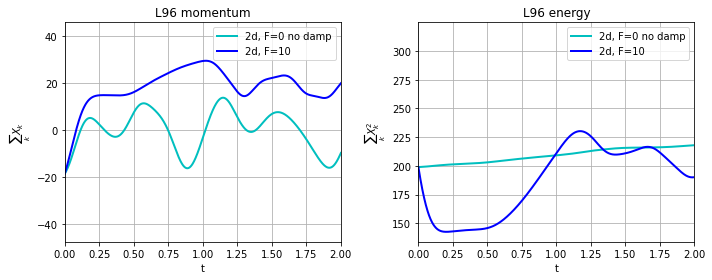

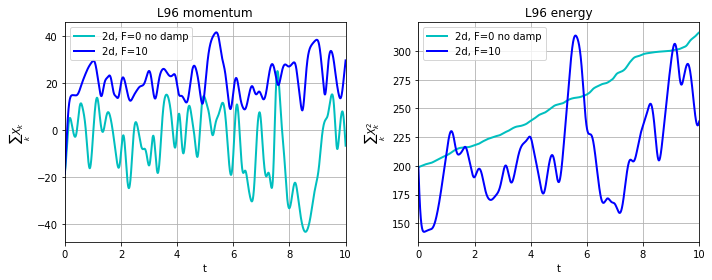

In [7]:
# Zero the forcing
Forcing_demo = 0
# Zero the damping via a linear parameterization term:
P_nodamp = [1.0, 0.0]

# Running the 2d and 1d versions of the GCM and GCM with squared forcing ("s")

gcm_2d_demo = GCM(Forcing_demo, naive_parameterization)
# The parameterization here is countering the decay term to demonstrate the conservation of this system
x2d_demo, t2d_demo = gcm_2d_demo(init_cond, dt, int(T / dt), P_nodamp)


for tup in [2, T]:
    F, ax = plt.subplots(1, 2, figsize=(10, 4))

    a = ax.ravel()[0]
    a.plot(
        t2d_demo,
        np.sum(x2d_demo, axis=1),
        label="2d, F=0 no damp",
        color="c",
        linewidth=2,
    )
    a.plot(t2d, np.sum(x2d, axis=1), label="2d, F=10", color="b", linewidth=2)
    a.legend()
    a.grid(True)
    a.set_title("L96 momentum")
    a.set_xlabel("t")
    a.set_ylabel(r"$\sum_k X_k$")
    a.set_xlim(0, tup)

    a = ax.ravel()[1]
    a.plot(
        t2d_demo,
        np.sum(x2d_demo**2, axis=1),
        label="2d, F=0 no damp",
        color="c",
        linewidth=2,
    )
    a.plot(t2d, np.sum(x2d**2, axis=1), label="2d, F=10", color="b", linewidth=2)
    a.legend()
    a.grid(True)
    a.set_title("L96 energy")
    a.set_xlabel("t")
    a.set_ylabel(r"$\sum_k X_k^2$")
    a.set_xlim(0, tup)

    F.tight_layout();

# Building a dataset of advection tendencies to learn

In the next section we are going to create a dataset of advection tendencies to learn

In [8]:
N = 50000

X = []
Xm1 = []
Xm2 = []
Xp1 = []
Adv = []

# randomize the initial condition and run 1000 time-step spin up with the real world model
init_condr = 10 * np.random.randn(8)
x_2, _ = gcm_2d(
    init_condr,
    0.001,
    1000,
    [
        0.0,
    ],
)

for ti in range(N):

    # Set the initial condition from the spin up/2d model
    init_condr_up = x_2[-1, :]

    # Real world values
    x_2, _ = gcm_2d(
        init_condr_up,
        0.001,
        1,
        [
            0.0,
        ],
    )
    # Simple model values
    x_1, _ = gcm_1d(
        init_condr_up,
        0.001,
        1,
        [
            0.0,
        ],
    )

    # This is the difference in the tendency term due to neglecting 2d processes per time-step
    Adv.append((x_2[-1, :] - x_1[-1, :]).ravel() / 0.001)

    # Storing the state variable and its rolled forms for plotting and learning convenience
    X.append(x_1[-1, :].ravel())
    Xm1.append(np.roll(x_1[-1, :], 1).ravel())
    Xm2.append(np.roll(x_1[-1, :], 2).ravel())
    Xp1.append(np.roll(x_1[-1, :], -1).ravel())

X = np.array(X)
Xm1 = np.array(Xm1)
Xm2 = np.array(Xm2)
Xp1 = np.array(Xp1)
Adv = np.array(Adv)

# Choosing a parameter to parameterize from

If we were simply looking at data and knew that the advection term was a missing force, we might start by looking at correlations with $X_k$ values, but we would quickly relize that this is not effective.

Even taking part of the actual advection term does not yield a useful feature parameter

Text(0, 0.5, 'Advection')

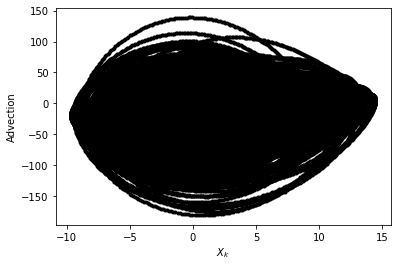

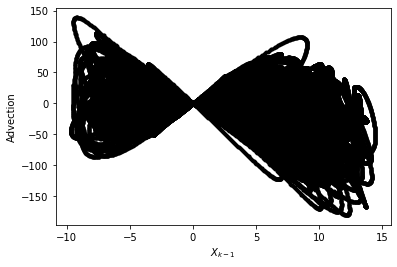

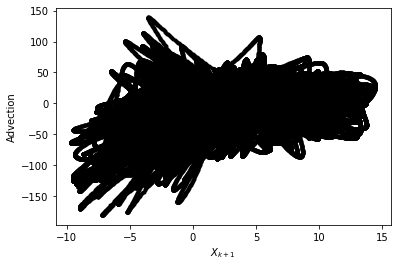

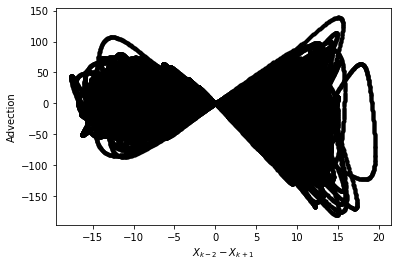

In [9]:
plt.figure()
plt.plot(X, Adv, "k.")
plt.xlabel("$X_{k}$")
plt.ylabel("Advection")

plt.figure()
plt.plot(Xm1, Adv, "k.")
plt.xlabel("$X_{k-1}$")
plt.ylabel("Advection")

plt.figure()
plt.plot(Xp1, Adv, "k.")
plt.xlabel("$X_{k+1}$")
plt.ylabel("Advection")

plt.figure()
plt.plot(Xm2 - Xp1, Adv, "k.")
plt.xlabel("$X_{k-2}-X_{k+1}$")
plt.ylabel("Advection")


Let's now just assume that we knew the form of the advection term.  We now get something that looks like a 1:1 linear relationship between the observed advection term and the correct feature parameter.  It is not perfect because the values we are using for $X_k$ are not consistent with the RK4 time stepping (if we used forward Euler we would get a perfit fit).

Fit (slope/bias):  [ 1.0011617  -0.00620157]


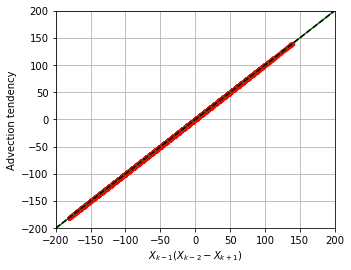

In [10]:
# We are going to assume we know the feature variable that we need to train the model.
# However, because of sampling across a time-step we will not fit a perfect 1:1,
# we end up with something very close to 1:1, but we will use a higher order polynomial that will
# fail when used outside the training data.

plt.figure(figsize=(5, 4))
Feature = -Xm1 * (np.array(Xm2) - np.array(Xp1))
plt.plot(Feature, Adv, "r.")
plt.xlabel("$X_{k-1}(X_{k-2}-X_{k+1})$")
plt.ylabel("Advection tendency")

# Here use a 10th order polynomial that is it to the advection tendencies.
# This parameterization will probably fail when used outside of the training data.
P = np.polyfit(np.array(Feature).ravel(), np.array(Adv).ravel(), 1)
print("Fit (slope/bias): ", P)
FS = [-200, 200]
plt.plot(FS, np.polyval(P, FS), "g-", label="polynomial parameterization")
plt.plot(FS, FS, "k--", label="1:1")
plt.xlim(-200, 200)
plt.ylim(-200, 200)
plt.grid(True)

In [11]:
# Create a new 1d GCM with a parameterization for the advection based on the known advection parameter
advection_parameterization = lambda param, X, F: np.polyval(
    param, -np.roll(X, 1) * (np.roll(X, 2) - np.roll(X, -1))
)
gcm_1d_padv = GCM_1d(Forcing, advection_parameterization)
gcm_1d_padv_x10 = GCM_1d(Forcing_x10, advection_parameterization)

# Here is the 1d GCM with the learned advection via the linear parameterization
xplinear, tplinear = gcm_1d_padv(init_cond, dt, int(T / dt), P)

# And the same 1d GCM applied out of sample
xplinear_x10, tplinear_x10 = gcm_1d_padv_x10(init_cond, dt, int(T / dt), P)

/net2/bgr/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  
/net2/bgr/anaconda3/envs/ML/lib/python3.7/site-packages/numpy/lib/polynomial.py:734: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


In [12]:
def CompExps(Exp1, ExpN):
    # Exp1 - reference experiment list
    # ExpN - list of comparison experiments

    try:
        T1 = Exp1[0]
        X1 = Exp1[1]
        L1 = Exp1[2]
        F, ax = plt.subplots(1, 2, figsize=(10, 4))
        a = ax.ravel()[0]
        a.plot(T1, np.sum(X1, axis=1), label=L1, color="k", linewidth=3)
        a = ax.ravel()[1]
        a.plot(T1, np.sum(X1**2, axis=1), label=L1, color="k", linewidth=3)

        F2, ax2 = plt.subplots(1, figsize=(5, 4))

        for Exp in ExpN:
            TN = Exp[0]
            XN = Exp[1]
            LN = Exp[2]

            a = ax.ravel()[0]
            a.plot(TN, np.sum(XN, axis=1), label=LN, linewidth=2)
            a = ax.ravel()[1]
            a.plot(TN, np.sum(XN**2, axis=1), label=LN, linewidth=2)

            _X = []
            _Y = []
            for ii in range(1, 100, 1):
                _X.append(np.percentile(np.sum(X1[int(5 // dt) :] ** 2, axis=1), ii))
                _Y.append(np.percentile(np.sum(XN[int(5 // dt) :] ** 2, axis=1), ii))
            ax2.plot(_X, _Y, ".-", label=LN)

        for ii in range(2):
            a = ax.ravel()[ii]
            a.legend()
            a.grid(True)
        ax[0].set(ylabel=r"$\sum_k X_k$", xlabel=r"$t$")
        ax[1].set(ylabel=r"$\sum_k X_k^2$", xlabel=r"$t$")
        F.tight_layout()

        ax2.grid(True)
        ax2.set(
            xlabel="e 2d model",
            ylabel="e 1d model w/ param",
            title="q-q plot of energy in 2d and parameterized model",
        )
        LIM = np.nanmax(list(_X) + list(_Y))
        ax2.set_xlim(0, LIM * 1.1)
        ax2.set_ylim(0, LIM * 1.1)
        ax2.plot([0, LIM], [0, LIM], "y-")
        pass
    except:
        pass

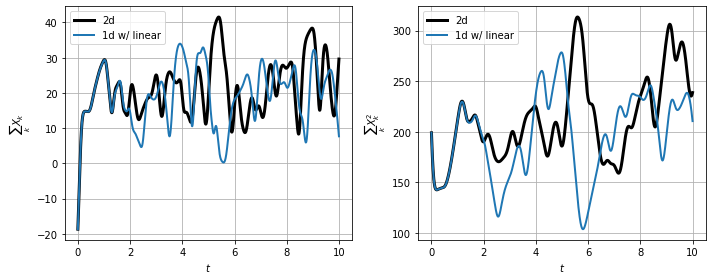

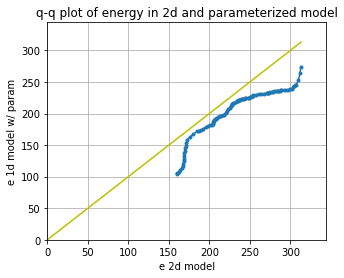

In [13]:
CompExps(
    [t2d, x2d, "2d"],
    [
        [tplinear, xplinear, "1d w/ linear"],
    ],
)

/net2/bgr/anaconda3/envs/ML/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/net2/bgr/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in square
  del sys.path[0]
/net2/bgr/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in square
/net2/bgr/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: All-NaN axis encountered


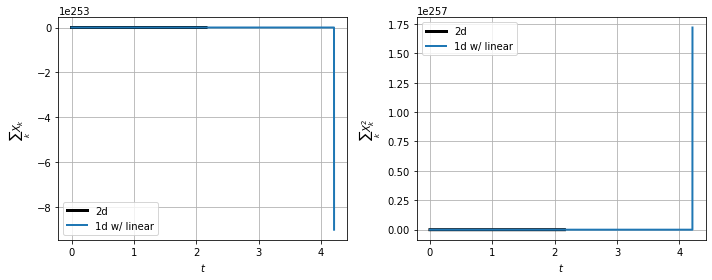

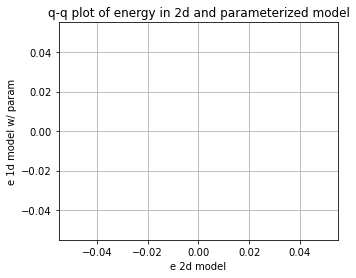

In [14]:
CompExps(
    [t2d_x10, x2d_x10, "2d"],
    [
        [tplinear_x10, xplinear_x10, "1d w/ linear"],
    ],
)

# What if we chose the wrong feature?

It turns out you can find features that are approximately correct and build a decent model for the advection


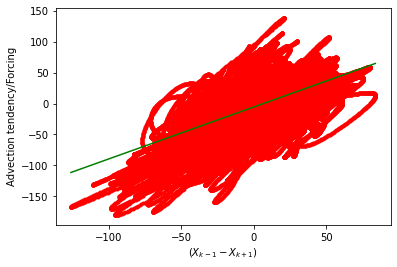

In [15]:
# Now we use a feature that is wrong to train the model

plt.figure()
Feature = -(np.array(Xm2) - np.array(Xp1) * np.array(Xm1))
plt.plot(Feature, Adv, "r.")
plt.xlabel("$(X_{k-1}-X_{k+1})$")
plt.ylabel("Advection tendency/Forcing")

# Here use a 10th order polynomial that is it to the advection tendencies.
# This parameterization will probably fail when used outside of the training data.
P_wrong = np.polyfit(np.array(Feature).ravel(), np.array(Adv).ravel(), 1)
FS = np.sort(np.array(Feature).ravel())
plt.plot(FS, np.polyval(P_wrong, FS), "g-", label="polynomial parameterization");

/net2/bgr/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  
/net2/bgr/anaconda3/envs/ML/lib/python3.7/site-packages/numpy/lib/polynomial.py:734: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
/net2/bgr/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in square
/net2/bgr/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in square


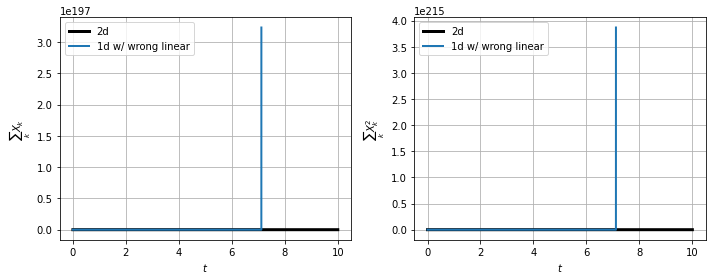

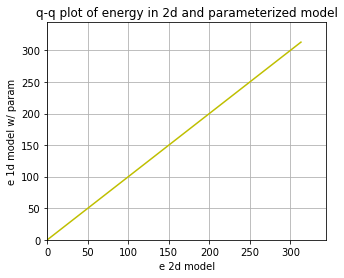

In [16]:
# Create a new 1d GCM with a 2d parameterization
advection_parameterization_wrong = lambda param, X, F: np.polyval(
    param, -(np.roll(X, 2) - np.roll(X, -1) * np.roll(X, 1))
)
gcm_1d_padv_wrong = GCM_1d(Forcing, advection_parameterization_wrong)

# Here is the 1d GCM with the learned advection via the 10th order polynomial
x_wrongp, t_wrongp = gcm_1d_padv_wrong(init_cond, dt, int(T / dt), P_wrong)

CompExps(
    [t2d, x2d, "2d"],
    [
        [t_wrongp, x_wrongp, "1d w/ wrong linear"],
    ],
)

Using the wrong feature gave us a very unstable model with advection that does not work.

In the following, we will try to learn the advection from a neural network.  This result shows that we need to do something quite skillful to have a stable system.

# Using the 3-layer non-local neural network

Now we can forget about neading to know the right form of the advection term.
We are instead just going to throw the information from the advection scheme to the non-local neural network and let it learn the advection for itself.



These follow the templates from the exercise led by Janni in week 4.



_I'm quite new to neural networks, so please let me know if you see any obvious mistakes in my approach!_

In [17]:
import torch
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
from sklearn.metrics import r2_score
from torch import nn, optim
from torch.autograd import Variable
from torch_lr_finder import LRFinder

np.random.seed(14)  # For reproducibility
torch.manual_seed(14)  # For reproducibility

# I'm going to start by scaling the data so that it is approximately order 1.

It looks like we can scaling $X$ and the advection with the forcing and forcing squared, respectively (we will come back to this assumption).

Advection RMS: 29.757755154501183
X RMS: 5.14384104405241
Scaled Advection RMS: 0.2975775515450118
Scaled X RMS: 0.514384104405241


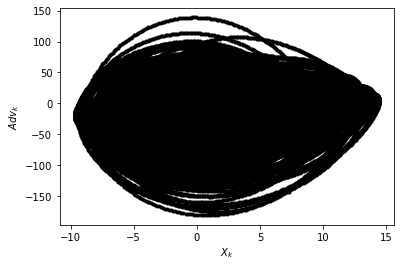

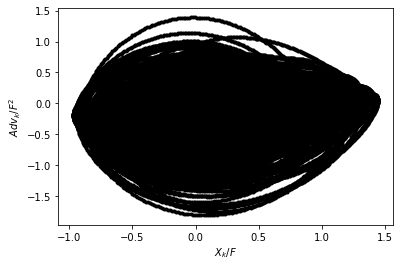

In [18]:
plt.figure()
plt.plot(X, Adv, "k.")
plt.xlabel("$X_k$")
plt.ylabel("$Adv_k$")

X_F = X / Forcing
Adv_F = Adv / Forcing**2

print("Advection RMS:", np.sqrt(np.mean(Adv**2)))
print("X RMS:", np.sqrt(np.mean(X**2)))

plt.figure()
plt.plot(X_F, Adv_F, "k.")
plt.xlabel("$X_k/F$")
plt.ylabel("$Adv_k/F^2$")

print("Scaled Advection RMS:", np.sqrt(np.mean(Adv_F**2)))
print("Scaled X RMS:", np.sqrt(np.mean(X_F**2)))

In [19]:
# Split into 80% training and 20% testing.

L = int(len(X) * 0.8)

# Create non local training data
# Define a data loader (8 inputs, 8 outputs)

# Define our X,Y pairs (state, subgrid tendency) for the linear regression local network.local_torch_dataset = Data.TensorDataset(
torch_dataset = Data.TensorDataset(
    torch.from_numpy(np.array(X_F[:L])).double(),
    torch.from_numpy(np.array(Adv_F[:L])).double(),
)

BATCH_SIZE = 1024  # Number of sample in each batch

loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True)


print("N training data: ", len(X_F[:L]))

N training data:  40000


In [20]:
print("N testing data: ", len(X_F[L:]))

# Define a test dataloader (8 inputs, 8 outputs)

torch_dataset_test = Data.TensorDataset(
    torch.from_numpy(np.array(X_F[L:])).double(),
    torch.from_numpy(np.array(Adv_F[L:])).double(),
)

loader_test = Data.DataLoader(
    dataset=torch_dataset_test, batch_size=BATCH_SIZE, shuffle=True
)

N testing data:  10000


In [21]:
# define network structure in pytorch
import torch.nn.functional as FF


class Net_ANN(nn.Module):
    def __init__(self):
        super(Net_ANN, self).__init__()
        self.linear1 = nn.Linear(8, 16)  # 8 inputs, 16 neurons for first hidden layer
        self.linear2 = nn.Linear(16, 16)  # 16 neurons for second hidden layer
        self.linear3 = nn.Linear(16, 8)  # 8 outputs
        # self.lin_drop = nn.Dropout(0.1) #regularization method to prevent overfitting.

    def forward(self, x):
        x = FF.relu(self.linear1(x))
        x = FF.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [22]:
def train_model(net, criterion, trainloader, optimizer):
    net.train()
    test_loss = 0
    for step, (batch_x, batch_y) in enumerate(trainloader):  # for each training step
        b_x = Variable(batch_x)  # Inputs
        b_y = Variable(batch_y)  # outputs
        if (
            len(b_x.shape) == 1
        ):  # If is needed to add a dummy dimension if our inputs are 1D (where each number is a different sample)
            prediction = torch.squeeze(
                net(torch.unsqueeze(b_x, 1))
            )  # input x and predict based on x
        else:
            prediction = net(b_x)
        loss = criterion(prediction, b_y)  # Calculating loss
        optimizer.zero_grad()  # clear gradients for next train
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients to update weights


def test_model(net, criterion, trainloader, optimizer, text="validation"):
    net.eval()  # Evaluation mode (important when having dropout layers)
    test_loss = 0
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(
            trainloader
        ):  # for each training step
            b_x = Variable(batch_x)  # Inputs
            b_y = Variable(batch_y)  # outputs
            if (
                len(b_x.shape) == 1
            ):  # If is needed to add a dummy dimension if our inputs are 1D (where each number is a different sample)
                prediction = torch.squeeze(
                    net(torch.unsqueeze(b_x, 1))
                )  # input x and predict based on x
            else:
                prediction = net(b_x)
            loss = criterion(prediction, b_y)  # Calculating loss
            test_loss = test_loss + loss.data.numpy()  # Keep track of the loss
        test_loss /= len(trainloader)  # dividing by the number of batches
        #         print(len(trainloader))
        print(text + " loss:", test_loss)
    return test_loss


criterion = torch.nn.MSELoss()  # MSE loss function

In [23]:
torch.manual_seed(14)  # For reproducibility
nn_3l = Net_ANN().double()

train loss: 0.027806309966000427
validation loss: 0.03338742759909256
train loss: 0.015522494623248423
validation loss: 0.01945873490935509
train loss: 0.012856452600687573
validation loss: 0.016529202653051904
train loss: 0.010475002558778923
validation loss: 0.013857635809177543
train loss: 0.010470859801775962
validation loss: 0.01409085770409745
train loss: 0.009852764356116992
validation loss: 0.014785889156426577
train loss: 0.00913809031773268
validation loss: 0.01342727545078215
train loss: 0.00919270964459333
validation loss: 0.013803081960084349
train loss: 0.009534602789943409
validation loss: 0.014028547249727883
train loss: 0.008257622734781454
validation loss: 0.011755548586476924
train loss: 0.00784493843756227
validation loss: 0.011168447715775572
train loss: 0.007871792340734592
validation loss: 0.01130734906272347
train loss: 0.007380950052883873
validation loss: 0.010690330300462274
train loss: 0.008794351166875134
validation loss: 0.013748586762050796
train loss: 0.

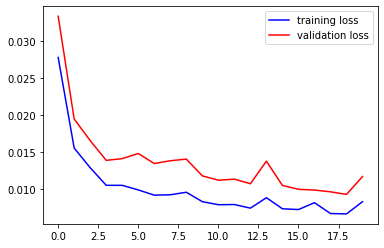

In [24]:
n_epochs = 20  # Number of epocs
optimizer = optim.Adam(nn_3l.parameters(), lr=0.03)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l, criterion, loader, optimizer)
    train_loss.append(test_model(nn_3l, criterion, loader, optimizer, "train"))
    validation_loss.append(test_model(nn_3l, criterion, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

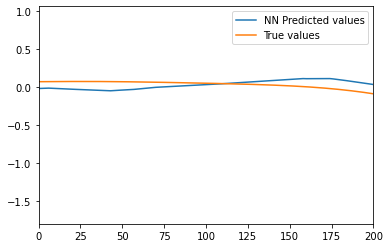

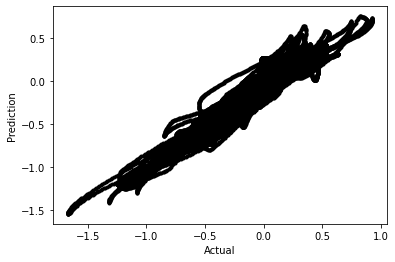

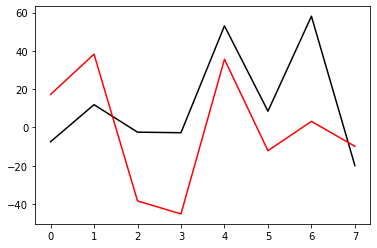

In [25]:
# The neural network does a pretty good job predicting the advection tendencies

preds22 = nn_3l(torch.from_numpy(np.array(X_F)).double())
plt.figure()
plt.plot(preds22.detach().numpy()[0:, 2], label="NN Predicted values")
plt.plot(Adv_F[:, 2], label="True values")
plt.legend()

plt.figure()
plt.plot(Adv_F[:, 2], preds22.detach().numpy()[0:, 2], "k.")
plt.xlabel("Actual")
plt.ylabel("Prediction")
pass

Xt = init_cond
Advr = -np.roll(Xt, 1) * (np.roll(Xt, 2) - np.roll(Xt, -1))
nnAdv = nn_3l(torch.from_numpy(np.array(Xt / Forcing)).double()).detach().numpy()

plt.figure()
plt.plot(Advr, "k-")
plt.plot(nnAdv * Forcing**2, "r-")

In [26]:
# - a GCM class including a neural network parameterization in rhs of equation for tendency
class GCM_network:
    def __init__(self, F, network, time_stepping=time_method):
        self.F = F
        self.network = network
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        if self.network.linear1.in_features == 1:
            X_torch = torch.from_numpy(X / self.F).double()
            X_torch = torch.unsqueeze(X_torch, 1)
        else:
            X_torch = torch.from_numpy(np.expand_dims(X / self.F, 0)).double()
        return L96_eq1_xdot(
            X,
            self.F + self.F**2 * np.squeeze(self.network(X_torch).data.numpy()),
            advect=False,
        )  # Adding NN parameterization

    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

In [27]:
# Run a test with the parameterization

gcm_nn = GCM_network(Forcing, nn_3l)
xnn, tnn = gcm_nn(init_cond, dt, int(T / (dt)), nn_3l)

gcm_nn_x10 = GCM_network(Forcing_x10, nn_3l)
xnn_x10, tnn_x10 = gcm_nn_x10(init_cond, dt, int(T / (dt)), nn_3l)

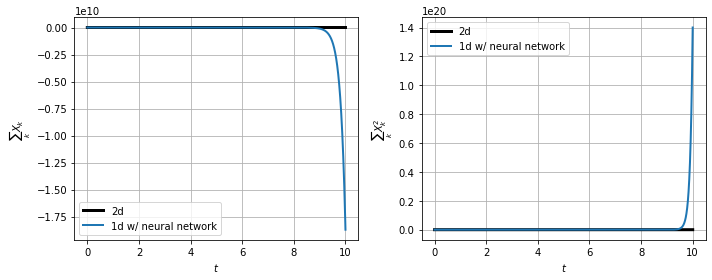

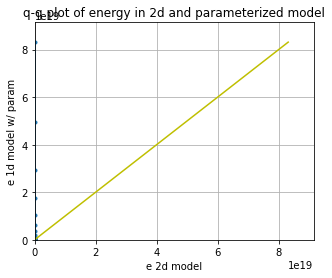

In [28]:
CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn, xnn, "1d w/ neural network"],
    ],
)

/net2/bgr/anaconda3/envs/ML/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/net2/bgr/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in square
  del sys.path[0]


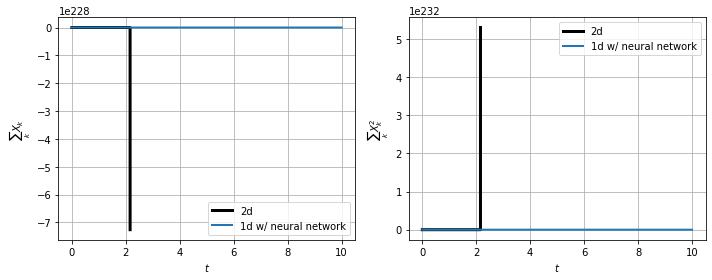

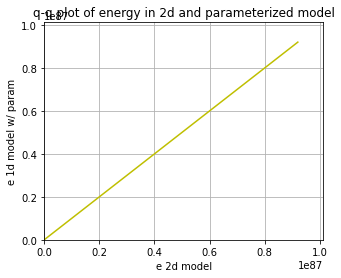

In [29]:
CompExps(
    [t2d_x10, x2d_x10, "2d"],
    [
        [tnn_x10, xnn_x10, "1d w/ neural network"],
    ],
)

In [30]:
def my_loss2(inpt, output, target):
    # In which we add conservation of "momentum" to our loss function
    loss = torch.mean(2 * (output - target) ** 2) + torch.mean(
        torch.sum(output, axis=1) ** 2
    )
    return loss

In [31]:
def train_model2(net, criterion, trainloader, optimizer):
    net.train()
    test_loss = 0
    for step, (batch_x, batch_y) in enumerate(trainloader):  # for each training step
        b_x = Variable(batch_x)  # Inputs
        b_y = Variable(batch_y)  # outputs
        if (
            len(b_x.shape) == 1
        ):  # If is needed to add a dummy dimension if our inputs are 1D (where each number is a different sample)
            prediction = torch.squeeze(
                net(torch.unsqueeze(b_x, 1))
            )  # input x and predict based on x
        else:
            prediction = net(b_x)
        loss = criterion(b_x, prediction, b_y)  # Calculating loss
        optimizer.zero_grad()  # clear gradients for next train
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients to update weights


def test_model2(net, criterion, trainloader, optimizer, text="validation"):
    net.eval()  # Evaluation mode (important when having dropout layers)
    test_loss = 0
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(
            trainloader
        ):  # for each training step
            b_x = Variable(batch_x)  # Inputs
            b_y = Variable(batch_y)  # outputs
            if (
                len(b_x.shape) == 1
            ):  # If is needed to add a dummy dimension if our inputs are 1D (where each number is a different sample)
                prediction = torch.squeeze(
                    net(torch.unsqueeze(b_x, 1))
                )  # input x and predict based on x
            else:
                prediction = net(b_x)
            loss = criterion(b_x, prediction, b_y)  # Calculating loss
            test_loss = test_loss + loss.data.numpy()  # Keep track of the loss
        test_loss /= len(trainloader)  # dividing by the number of batches
        #         print(len(trainloader))
        print(text + " loss:", test_loss)
    return test_loss

In [32]:
torch.manual_seed(14)  # For reproducibility
nn_3l_loss2 = Net_ANN().double()

train loss: 0.14525318805451148
validation loss: 0.1410566018642861
train loss: 0.11146990705605828
validation loss: 0.11152683341702804
train loss: 0.08531280002050026
validation loss: 0.09315141423013254
train loss: 0.07350083683860467
validation loss: 0.08130148452968912
train loss: 0.060556589378488845
validation loss: 0.06770017477534296
train loss: 0.0545573680262641
validation loss: 0.06238966749914634
train loss: 0.050780309414355296
validation loss: 0.05979021465004297
train loss: 0.04830985343262146
validation loss: 0.05491476056832688
train loss: 0.0480117902578755
validation loss: 0.054550888025179975
train loss: 0.045557077204676784
validation loss: 0.052404215284515
train loss: 0.050795559467502985
validation loss: 0.05659772770024404
train loss: 0.043447985506593026
validation loss: 0.050814080589169176
train loss: 0.04332648821360594
validation loss: 0.05082919783894968
train loss: 0.04152745776617327
validation loss: 0.04934856531269395
train loss: 0.04228600111932894


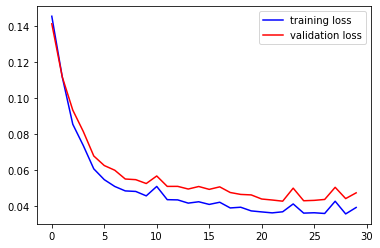

In [33]:
n_epochs = 30  # Number of epocs
optimizer = optim.Adam(nn_3l_loss2.parameters(), lr=0.02)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model2(nn_3l_loss2, my_loss2, loader, optimizer)
    train_loss.append(test_model2(nn_3l_loss2, my_loss2, loader, optimizer, "train"))
    validation_loss.append(test_model2(nn_3l_loss2, my_loss2, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

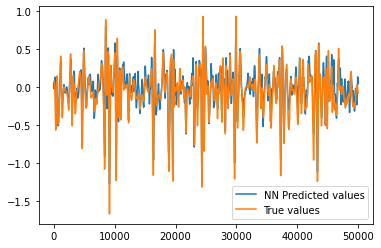

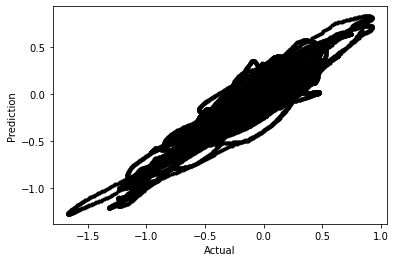

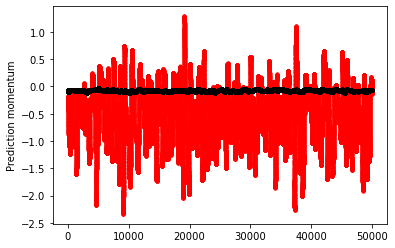

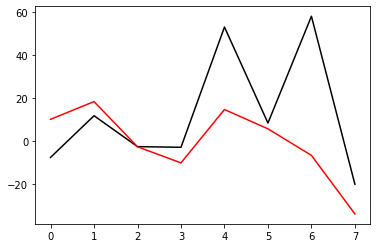

In [34]:
# The neural network does a pretty good job predicting the advection tendencies

preds22o = nn_3l(torch.from_numpy(np.array(X_F)).double())
preds22 = nn_3l_loss2(torch.from_numpy(np.array(X_F)).double())
plt.figure()
plt.plot(preds22.detach().numpy()[0:, 2], label="NN Predicted values")
plt.plot(Adv_F[:, 2], label="True values")
plt.legend()

plt.figure()
plt.plot(Adv_F[:, 2], preds22.detach().numpy()[0:, 2], "k.")
plt.xlabel("Actual")
plt.ylabel("Prediction")

plt.figure()
plt.plot(np.sum(preds22o.detach().numpy(), axis=1), "r.")
plt.plot(np.sum(preds22.detach().numpy(), axis=1), "k.")
plt.ylabel("Prediction momentum")

Xt = init_cond
Advr = -np.roll(Xt, 1) * (np.roll(Xt, 2) - np.roll(Xt, -1))
nnAdv = nn_3l_loss2(torch.from_numpy(np.array(Xt / Forcing)).double()).detach().numpy()

plt.figure()
plt.plot(Advr, "k-", label="actual")
plt.plot(nnAdv * Forcing**2, "r-", label="predicted")
pass;

In [35]:
gcm_nn2 = GCM_network(Forcing, nn_3l_loss2)
xnn2, tnn2 = gcm_nn2(init_cond, dt, int(T / (dt)), nn_3l_loss2)

gcm_nn2_x10 = GCM_network(Forcing_x10, nn_3l_loss2)
xnn2_x10, tnn2_x10 = gcm_nn2_x10(init_cond, dt, int(T / (dt)), nn_3l_loss2)

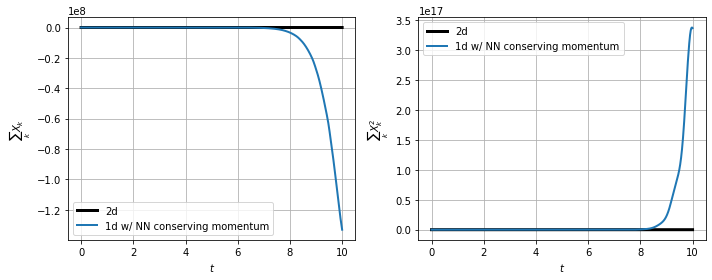

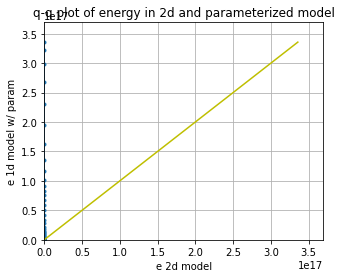

In [36]:
CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn2, xnn2, "1d w/ NN conserving momentum"],
    ],
)

/net2/bgr/anaconda3/envs/ML/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/net2/bgr/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in square
  del sys.path[0]


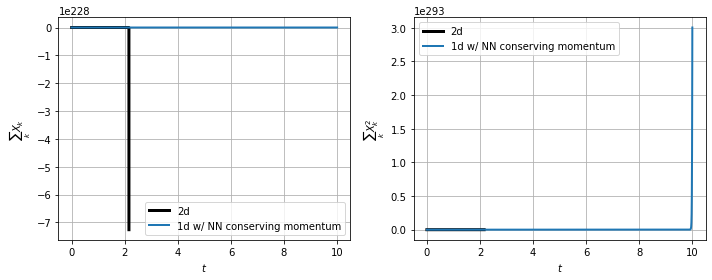

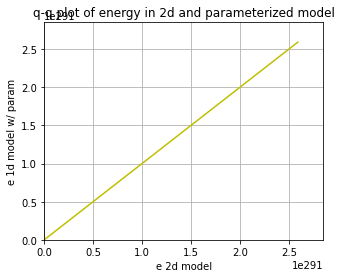

In [37]:
CompExps(
    [t2d_x10, x2d_x10, "2d"],
    [
        [tnn2_x10, xnn2_x10, "1d w/ NN conserving momentum"],
    ],
)

# How about with some regularization?

In [38]:
torch.manual_seed(14)  # For reproducibility
nn_3l_loss3 = Net_ANN().double()

train loss: 0.16579065029393938
validation loss: 0.15499097681366703
train loss: 0.14926573665192572
validation loss: 0.14323137518692666
train loss: 0.1406335224452818
validation loss: 0.13597032714808552
train loss: 0.1308623576390843
validation loss: 0.1291846466497783
train loss: 0.12723074242902543
validation loss: 0.12605576221934142
train loss: 0.1264709952978287
validation loss: 0.1265513443892068
train loss: 0.12553793742702213
validation loss: 0.12488535092134101
train loss: 0.12116740130915507
validation loss: 0.12205285224708384
train loss: 0.11890633967669606
validation loss: 0.12017104844007243
train loss: 0.11651745269669544
validation loss: 0.11806960875048114
train loss: 0.11637859661436176
validation loss: 0.11755907672259555
train loss: 0.11370023795179225
validation loss: 0.11597579887099511
train loss: 0.11262012142059126
validation loss: 0.11448235950936944
train loss: 0.10943062368938303
validation loss: 0.11293791241020668
train loss: 0.1093506147575543
validati

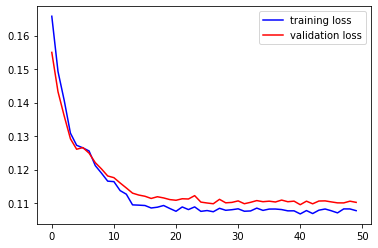

In [39]:
n_epochs = 50  # Number of epocs
optimizer = optim.Adam(nn_3l_loss3.parameters(), lr=0.01, weight_decay=0.01)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model2(nn_3l_loss3, my_loss2, loader, optimizer)
    train_loss.append(test_model2(nn_3l_loss3, my_loss2, loader, optimizer, "train"))
    validation_loss.append(test_model2(nn_3l_loss3, my_loss2, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

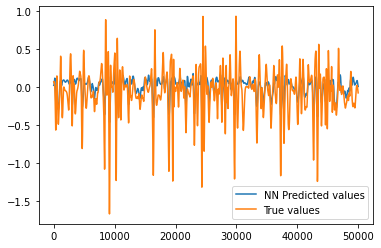

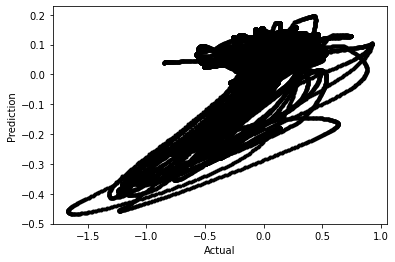

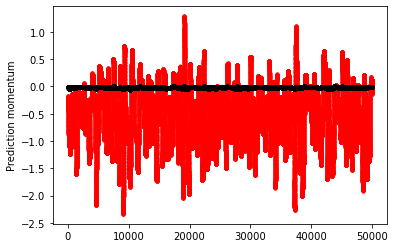

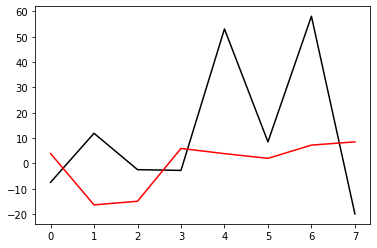

In [40]:
# The neural network does a pretty good job predicting the advection tendencies

preds22o = nn_3l(torch.from_numpy(np.array(X_F)).double())
preds22 = nn_3l_loss3(torch.from_numpy(np.array(X_F)).double())
plt.figure()
plt.plot(preds22.detach().numpy()[0:, 2], label="NN Predicted values")
plt.plot(Adv_F[:, 2], label="True values")
plt.legend()

plt.figure()
plt.plot(Adv_F[:, 2], preds22.detach().numpy()[0:, 2], "k.")
plt.xlabel("Actual")
plt.ylabel("Prediction")

plt.figure()
plt.plot(np.sum(preds22o.detach().numpy(), axis=1), "r.")
plt.plot(np.sum(preds22.detach().numpy(), axis=1), "k.")
plt.ylabel("Prediction momentum")

Xt = init_cond
Advr = -np.roll(Xt, 1) * (np.roll(Xt, 2) - np.roll(Xt, -1))
nnAdv = nn_3l_loss3(torch.from_numpy(np.array(Xt / Forcing)).double()).detach().numpy()

plt.figure()
plt.plot(Advr, "k-", label="actual")
plt.plot(nnAdv * Forcing**2, "r-", label="predicted")
pass;

In [41]:
gcm_nn3 = GCM_network(Forcing, nn_3l_loss3)
xnn3, tnn3 = gcm_nn3(init_cond, dt, int(T / (dt)), nn_3l_loss3)

gcm_nn3_x10 = GCM_network(Forcing_x10, nn_3l_loss3)
xnn3_x10, tnn3_x10 = gcm_nn3_x10(init_cond, dt, int(T / (dt)), nn_3l_loss3)

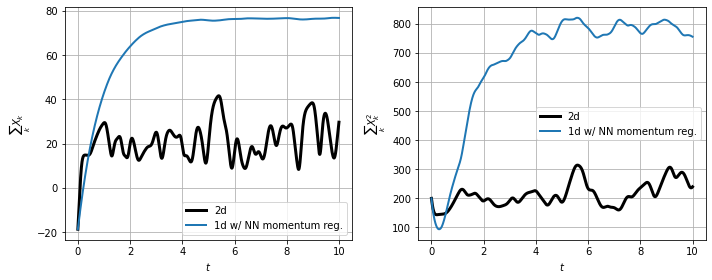

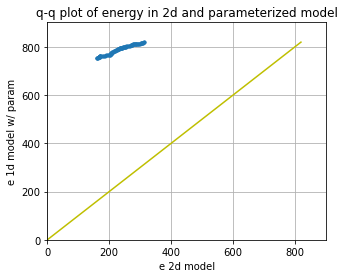

In [42]:
CompExps([t2d,x2d,'2d'], [[tnn3,xnn3,'1d w/ NN momentum reg.'], [[t1d,x1d,'1d ']]
        )

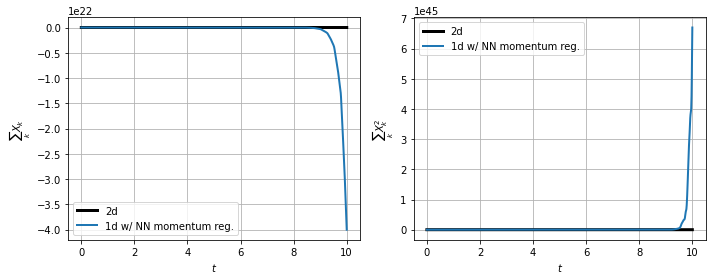

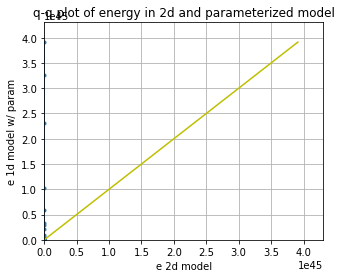

In [43]:
CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn3_x10, xnn3_x10, "1d w/ NN momentum reg."],
    ],
)

# Try a different scaling term

Could scaling with the Forcing be the issue?

In [44]:
# Use the advection tendencies, splitting into 80% training and 20% testing.

L = int(len(X) * 0.8)
print(L)

ScX = np.sqrt(np.mean(X**2))
X_S = X / ScX
ScA = np.sqrt(np.mean(Adv**2))
Adv_S = Adv / ScA

# Create non local training data
# Define a data loader (8 inputs, 8 outputs)

# Define our X,Y pairs (state, subgrid tendency) for the linear regression local network.local_torch_dataset = Data.TensorDataset(
torch_dataset = Data.TensorDataset(
    torch.from_numpy(np.array(X_S[:L])).double(),
    torch.from_numpy(np.array(Adv_S[:L])).double(),
)

BATCH_SIZE = 1024  # Number of sample in each batch

loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Define a test dataloader (8 inputs, 8 outputs)

torch_dataset_test = Data.TensorDataset(
    torch.from_numpy(np.array(X_S[L:])).double(),
    torch.from_numpy(np.array(Adv_S[L:])).double(),
)

loader_test = Data.DataLoader(
    dataset=torch_dataset_test, batch_size=BATCH_SIZE, shuffle=True
)

40000


In [45]:
torch.manual_seed(14)  # For reproducibility
nn_3l_loss4 = Net_ANN().double()

train loss: 1.3681752714328994
validation loss: 1.391962668717579
train loss: 0.9011502772068825
validation loss: 0.9852437970362267
train loss: 0.7278986822420841
validation loss: 0.7862180538315828
train loss: 0.6446226345652313
validation loss: 0.6979588712059025
train loss: 0.5845171826599014
validation loss: 0.6539705207831646
train loss: 0.5411244303508285
validation loss: 0.611328752191106
train loss: 0.5240889602271969
validation loss: 0.591975926057591
train loss: 0.503873132638851
validation loss: 0.5663706685477654
train loss: 0.4969634789969839
validation loss: 0.5652073673117425
train loss: 0.4863031025558756
validation loss: 0.554563780751476
train loss: 0.48714229414121607
validation loss: 0.5490252496857627
train loss: 0.4823786916274545
validation loss: 0.549035764776083
train loss: 0.47470288877279276
validation loss: 0.5384986656774667
train loss: 0.4664004360050513
validation loss: 0.5353526954061639
train loss: 0.466273914893329
validation loss: 0.5312159977911647


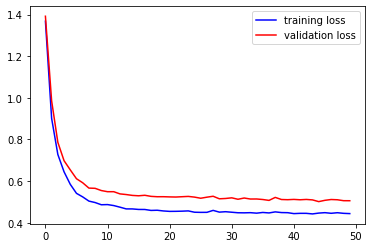

In [46]:
n_epochs = 50  # Number of epocs
optimizer = optim.Adam(nn_3l_loss4.parameters(), lr=0.01, weight_decay=0.02)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model2(nn_3l_loss4, my_loss2, loader, optimizer)
    train_loss.append(test_model2(nn_3l_loss4, my_loss2, loader, optimizer, "train"))
    validation_loss.append(test_model2(nn_3l_loss4, my_loss2, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

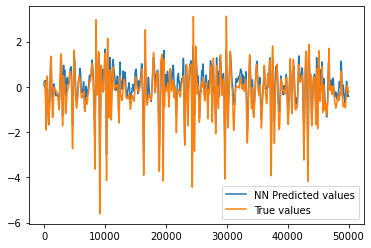

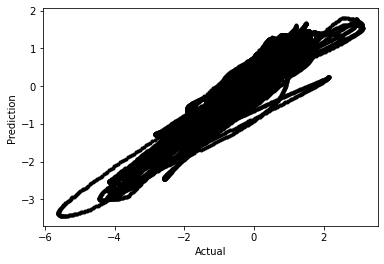

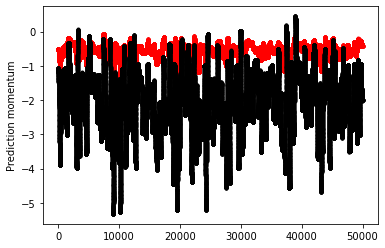

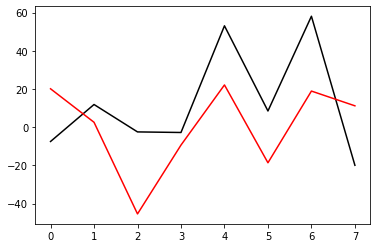

In [47]:
# The neural network does a pretty good job predicting the advection tendencies

preds22o = nn_3l_loss3(torch.from_numpy(np.array(X_S)).double())
preds22 = nn_3l_loss4(torch.from_numpy(np.array(X_S)).double())
plt.figure()
plt.plot(preds22.detach().numpy()[0:, 2], label="NN Predicted values")
plt.plot(Adv_S[:, 2], label="True values")
plt.legend()

plt.figure()
plt.plot(Adv_S[:, 2], preds22.detach().numpy()[0:, 2], "k.")
plt.xlabel("Actual")
plt.ylabel("Prediction")

plt.figure()
plt.plot(np.sum(preds22o.detach().numpy(), axis=1) * Forcing, "r.")
plt.plot(np.sum(preds22.detach().numpy(), axis=1) * ScA, "k.")
plt.ylabel("Prediction momentum")

Xt = init_cond
Advr = -np.roll(Xt, 1) * (np.roll(Xt, 2) - np.roll(Xt, -1))
nnAdv = nn_3l_loss4(torch.from_numpy(np.array(Xt / Forcing)).double()).detach().numpy()

plt.figure()
plt.plot(Advr, "k-", label="actual")
plt.plot(nnAdv * Forcing**2, "r-", label="predicted")
pass;

In [48]:
# - a GCM class including a neural network parameterization in rhs of equation for tendency
class GCM_network_S:
    def __init__(self, F, network, time_stepping=time_method):
        self.F = F
        self.network = network
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        if self.network.linear1.in_features == 1:
            X_torch = torch.from_numpy(X / ScX).double()
            X_torch = torch.unsqueeze(X_torch, 1)
        else:
            X_torch = torch.from_numpy(np.expand_dims(X / ScX, 0)).double()
        return L96_eq1_xdot(
            X,
            self.F + ScA * np.squeeze(self.network(X_torch).data.numpy()),
            advect=False,
        )  # Adding NN parameterization

    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

In [49]:
gcm_nn4 = GCM_network_S(Forcing, nn_3l_loss4)
xnn4, tnn4 = gcm_nn4(init_cond, dt, int(T / dt), nn_3l_loss4)

gcm_nn4_x10 = GCM_network_S(Forcing_x10, nn_3l_loss4)
xnn4_x10, tnn4_x10 = gcm_nn4_x10(init_cond, dt, int(T / dt), nn_3l_loss4)

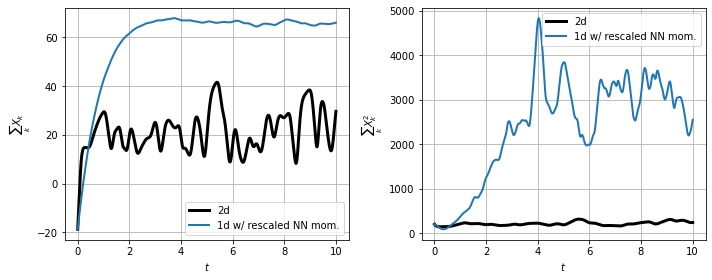

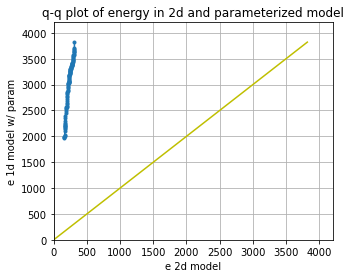

In [50]:
CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn4, xnn4, "1d w/ rescaled NN mom."],
    ],
)

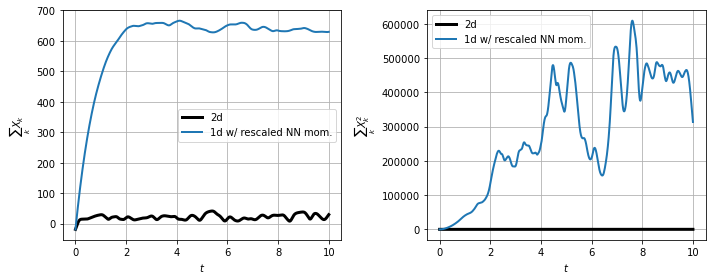

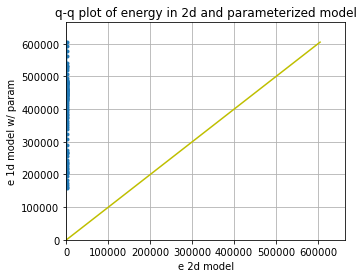

In [51]:
CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn4_x10, xnn4_x10, "1d w/ rescaled NN mom."],
    ],
)

In [52]:
def my_loss3(inpt, output, target):
    # In which we replace conservation of "momentum" with conservation of "energy"
    loss = torch.mean(2 * (output - target) ** 2) + WT * torch.mean(
        torch.sum(inpt * output, axis=1) ** 2
    )
    return loss

train loss: 1.2826061494668313
validation loss: 1.3455059528678692
train loss: 0.9149025646754556
validation loss: 1.0997036069131914
train loss: 0.732444627481474
validation loss: 0.9384637310184555
train loss: 0.6379298918237817
validation loss: 0.8460253765953549
train loss: 0.5761035816953372
validation loss: 0.7604782247348131
train loss: 0.5383015088854007
validation loss: 0.7377350251595804
train loss: 0.5105438440157084
validation loss: 0.7314516144621489
train loss: 0.4855887124780443
validation loss: 0.7343960807804357
train loss: 0.48758971352170033
validation loss: 0.7347514783167745
train loss: 0.4594611358711118
validation loss: 0.6489331681669646
train loss: 0.4502717413706285
validation loss: 0.6872370074865763
train loss: 0.4340291909027127
validation loss: 0.6864948822070741
train loss: 0.452794693189179
validation loss: 0.6742118368453638
train loss: 0.4302956506952471
validation loss: 0.7245060186261737
train loss: 0.405715603786214
validation loss: 0.65686495267823

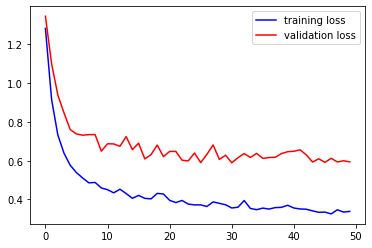

In [53]:
WT = 1

torch.manual_seed(14)  # For reproducibility
nn_3l_loss5 = Net_ANN().double()

n_epochs = 50  # Number of epocs
optimizer = optim.Adam(nn_3l_loss5.parameters(), lr=0.01)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model2(nn_3l_loss5, my_loss3, loader, optimizer)
    train_loss.append(test_model2(nn_3l_loss5, my_loss3, loader, optimizer, "train"))
    validation_loss.append(test_model2(nn_3l_loss5, my_loss3, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

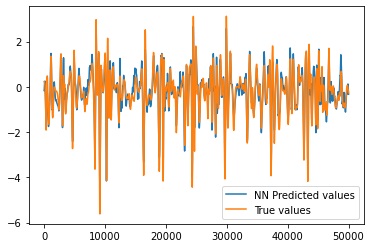

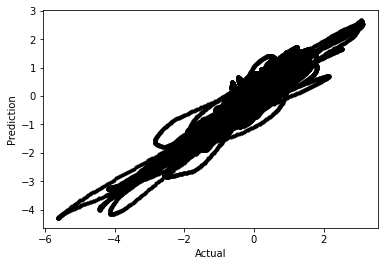

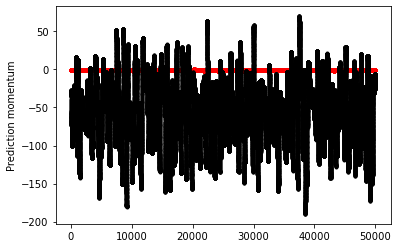

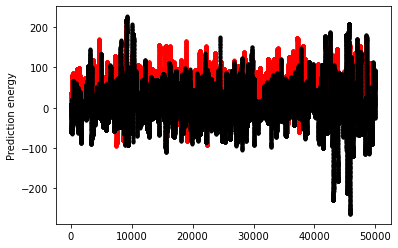

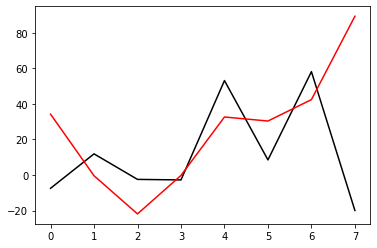

In [57]:
# The neural network does a pretty good job predicting the advection tendencies

preds22o = nn_3l_loss4(torch.from_numpy(np.array(X_S)).double())
preds22 = nn_3l_loss5(torch.from_numpy(np.array(X_S)).double())
plt.figure()
plt.plot(preds22.detach().numpy()[:, 2], label="NN Predicted values")
plt.plot(Adv_S[:, 2], label="True values")
plt.legend()

plt.figure()
plt.plot(Adv_S[:, 2], preds22.detach().numpy()[:, 2], "k.")
plt.xlabel("Actual")
plt.ylabel("Prediction")

plt.figure()
plt.plot(np.sum(preds22o.detach().numpy(), axis=1) * Forcing, "r.")
plt.plot(np.sum(preds22.detach().numpy(), axis=1) * ScA, "k.")
plt.ylabel("Prediction momentum")

plt.figure()
plt.plot(np.sum(X * preds22o.detach().numpy() * Forcing, axis=1), "r.")
plt.plot(np.sum(X * preds22.detach().numpy() * ScA, axis=1), "k.")
plt.ylabel("Prediction energy")

Xt = init_cond
Advr = -np.roll(Xt, 1) * (np.roll(Xt, 2) - np.roll(Xt, -1))
nnAdv = nn_3l_loss5(torch.from_numpy(np.array(Xt / Forcing)).double()).detach().numpy()

plt.figure()
plt.plot(Advr, "k-", label="actual")
plt.plot(nnAdv * Forcing**2, "r-", label="predicted")
pass;

In [58]:
gcm_nn5 = GCM_network_S(Forcing, nn_3l_loss5)
xnn5, tnn5 = gcm_nn5(init_cond, dt, int(T / dt), nn_3l_loss5)

gcm_nn5_x10 = GCM_network_S(Forcing_x10, nn_3l_loss5)
xnn5_x10, tnn5_x10 = gcm_nn5_x10(init_cond, dt, int(T / dt), nn_3l_loss5)

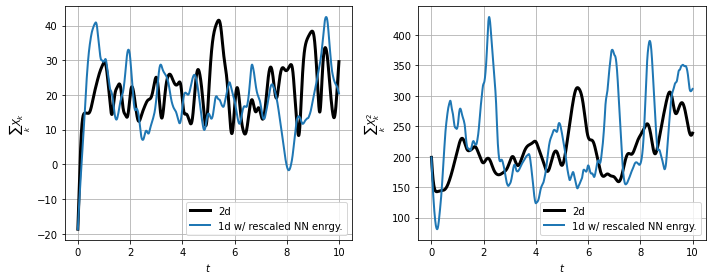

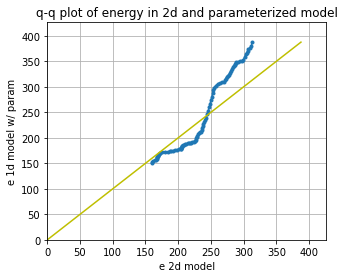

In [59]:
CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn5, xnn5, "1d w/ rescaled NN enrgy."],
    ],
)

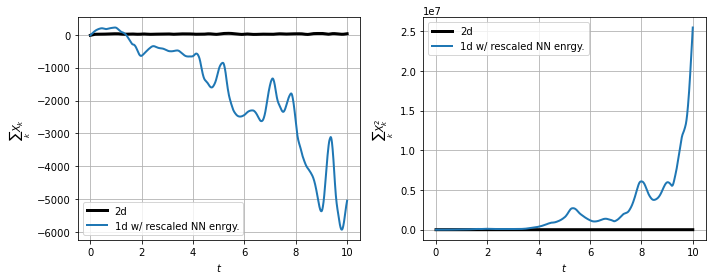

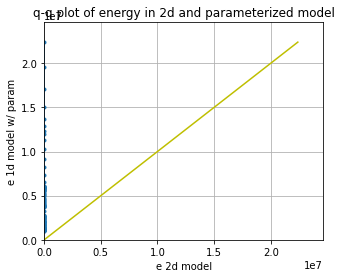

In [60]:
CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn5_x10, xnn5_x10, "1d w/ rescaled NN enrgy."],
    ],
)

train loss: 1.6670244031318098
validation loss: 1.6169808597865494
train loss: 1.2733193764897834
validation loss: 1.429655216126067
train loss: 1.1611719911257845
validation loss: 1.3392075945638213
train loss: 0.9882299755031727
validation loss: 1.2606370151935224
train loss: 0.9330834847969373
validation loss: 1.1915211785409252
train loss: 0.8593020412617743
validation loss: 1.1732642900748762
train loss: 0.8252283850143766
validation loss: 1.1785956411334026
train loss: 0.8021176446651618
validation loss: 1.186613968152743
train loss: 0.8101464598994956
validation loss: 1.246393595311505
train loss: 0.7717795630389455
validation loss: 1.141093198424709
train loss: 0.8134263662898462
validation loss: 1.2113765952925197
train loss: 0.7351982002759915
validation loss: 1.171073626020301
train loss: 0.7080299670989753
validation loss: 1.1485954991234824
train loss: 0.7227222047724092
validation loss: 1.1771556523817996
train loss: 0.7330381393766325
validation loss: 1.2215120814403466


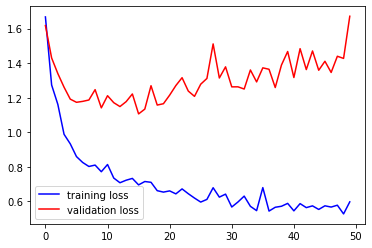

In [61]:
WT = 5

torch.manual_seed(14)  # For reproducibility
nn_3l_loss6 = Net_ANN().double()

n_epochs = 50  # Number of epocs
optimizer = optim.Adam(nn_3l_loss6.parameters(), lr=0.01)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model2(nn_3l_loss6, my_loss3, loader, optimizer)
    train_loss.append(test_model2(nn_3l_loss6, my_loss3, loader, optimizer, "train"))
    validation_loss.append(test_model2(nn_3l_loss6, my_loss3, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

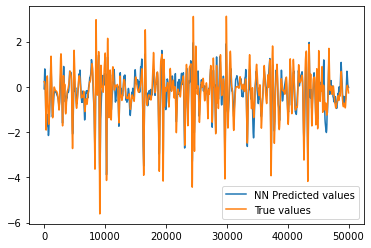

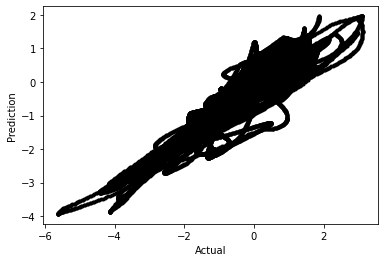

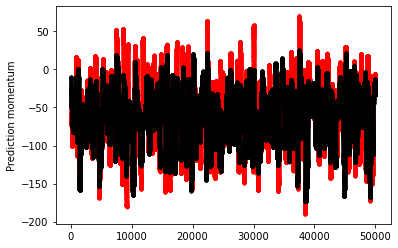

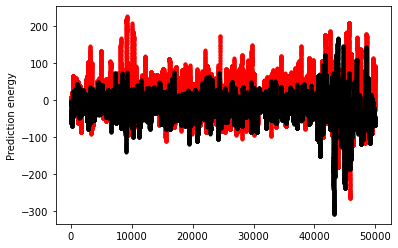

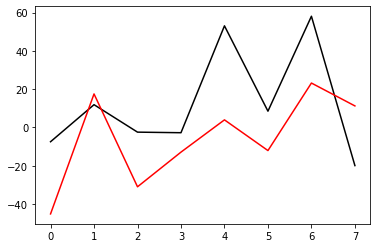

In [62]:
# The neural network does a pretty good job predicting the advection tendencies

preds22o = nn_3l_loss5(torch.from_numpy(np.array(X_S)).double())
preds22 = nn_3l_loss6(torch.from_numpy(np.array(X_S)).double())
plt.figure()
plt.plot(preds22.detach().numpy()[0:, 2], label="NN Predicted values")
plt.plot(Adv_S[:, 2], label="True values")
plt.legend()

plt.figure()
plt.plot(Adv_S[:, 2], preds22.detach().numpy()[0:, 2], "k.")
plt.xlabel("Actual")
plt.ylabel("Prediction")

plt.figure()
plt.plot(np.sum(preds22o.detach().numpy(), axis=1) * ScA, "r.")
plt.plot(np.sum(preds22.detach().numpy(), axis=1) * ScA, "k.")
plt.ylabel("Prediction momentum")

plt.figure()
plt.plot(np.sum(X * preds22o.detach().numpy(), axis=1) * ScA, "r.")
plt.plot(np.sum(X * preds22.detach().numpy(), axis=1) * ScA, "k.")
plt.ylabel("Prediction energy")

Xt = init_cond
Advr = -np.roll(Xt, 1) * (np.roll(Xt, 2) - np.roll(Xt, -1))
nnAdv = nn_3l_loss6(torch.from_numpy(np.array(Xt / Forcing)).double()).detach().numpy()

plt.figure()
plt.plot(Advr, "k-", label="actual")
plt.plot(nnAdv * Forcing**2, "r-", label="predicted")
pass;

In [63]:
gcm_nn6 = GCM_network_S(Forcing, nn_3l_loss6)
xnn6, tnn6 = gcm_nn6(init_cond, dt, int(50 / dt), nn_3l_loss6)

gcm_nn6_x10 = GCM_network_S(Forcing_x10, nn_3l_loss6)
xnn6_x10, tnn6_x10 = gcm_nn6_x10(init_cond, dt, int(5 / dt), nn_3l_loss6)

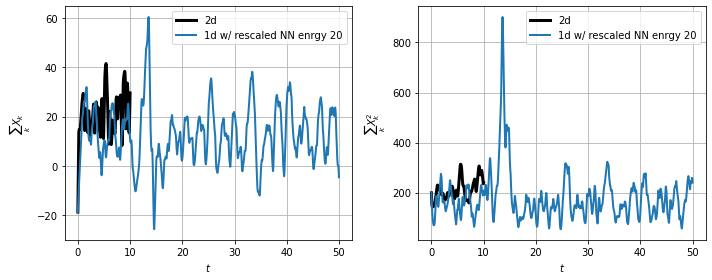

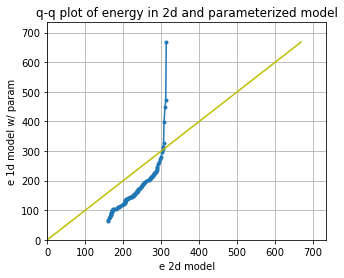

In [64]:
CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn6, xnn6, "1d w/ rescaled NN enrgy 20"],
    ],
)

/net2/bgr/anaconda3/envs/ML/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/net2/bgr/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in square
  del sys.path[0]


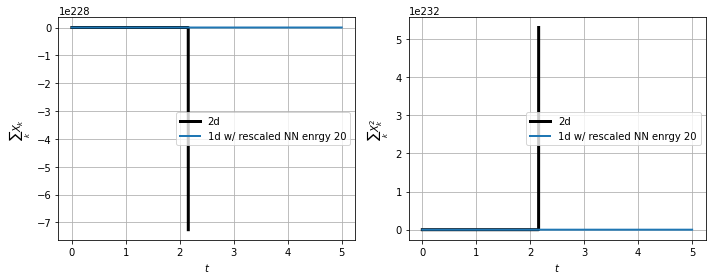

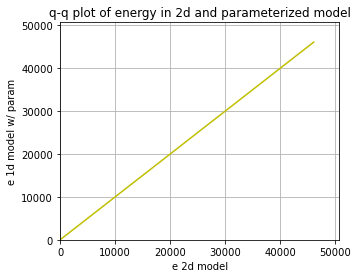

In [65]:
CompExps(
    [t2d_x10, x2d_x10, "2d"],
    [
        [tnn6_x10, xnn6_x10, "1d w/ rescaled NN enrgy 20"],
    ],
)